# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 1

In [2]:
cluster = '4'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 436
Num noneffect sequences: 436


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
33   chr11   60251676   60251677     rs636317      T         C   C      T   
277  chr19   45326535   45326536     rs344791      C         G   G      C   
44   chr12   33530906   33530907     rs935534      G         A   G      A   
424   chr8   27369272   27369273     rs755951      A         C   A    C,T   
89   chr17    4842203    4842204    rs7218130      A         G   A      G   
392   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
183  chr17   45959569   45959570   rs62063279      G         A   G    A,C   
336   chr3  122458998  122458999   rs56118506      T         C   C      T   
185  chr17   45966269   45966270   rs62063292      T         C   C      T   
218  chr17   62065536   62065537  rs118039704      G         A   G      A   
245  chr19   44890258   44890259  rs117310449      T         C   C      T   
348   chr4     960458     960459    rs3733345      T         G   G    A,T   
382   chr4   89818510   89818511    rs2737022      A         C   A      C   
145  chr17   45852871   45852872   rs79589869      C         A   C      A   
151  chr17   45894775   45894776   rs11575896      G         A   G      A   
369   chr4   89723356   89723357    rs8180214      G         A   G      A   
410   chr6   27762683   27762684    rs7759217      G         A   A      G   
398   chr5  102971887  102971888    rs6881225      T         C   T      C   
380   chr4   89800728   89800729   rs17016188      T         C   T      C   
87   chr17    4842178    4842179    rs7218117      A         G   A      G   
53   chr14   54882150   54882151   rs11158026      T         C   C  A,G,T   
27   chr11   60169283   60169284     rs617135      G         A   A      G   
239  chr19   44644418   44644419   rs10426401      T         G   T      G   
307   chr2  134762963  134762964   rs13033373      T         C   T      C   
256  chr19   44954954   44954955  rs117316645      A         G   G    A,C   
317   chr3   48898149   48898150    rs7431710      G         A   G    A,C   
124  chr17   45740531   45740532   rs80157557      G         A   G      A   
149  chr17   45894418   45894419   rs11575895      G         A   A      G   
408   chr6   27754284   27754285    rs4713121      T         C   T      C   
364   chr4   89717462   89717463    rs7681815      G         C   G    A,C   
..     ...        ...        ...          ...    ...       ...  ..    ...   
333   chr3   52531185   52531186   rs59078569      G         A   G      A   
419   chr7   65960529   65960530   rs62470932      T         C   C      T   
301   chr2  134712198  134712199    rs6747870      G         A   A      G   
40   chr11  121556160  121556161    rs7131432      A         T   T      A   
334   chr3   52771464   52771465  rs147131488      T         G   G    A,T   
94   chr17    4881683    4881684  rs145035851      T         C   C      T   
176  chr17   45941032   45941033   rs62061733      G         A   A      G   
396   chr5  102910364  102910365   rs17154825      T         C   T      C   
213  chr17   46287462   46287463    rs2732613      A         C   A    C,T   
80   chr16   31074148   31074149    rs2303222      T         C   T    A,C   
356   chr4   18021068   18021069    rs7659195      T         C   T      C   
303   chr2  134712485  134712486   rs17733977      G         A   G      A   
248  chr19   44891078   44891079   rs71352238      C         T   T      C   
387   chr4   89836157   89836158    rs1372519      G         A   A      G   
254  chr19   44954888   44954889    rs3760629      A         C   A      C   
190  chr17   45997252   45997253   rs62063854      G         A   G      A   
390   chr4   89836583   89836584    rs2619361      A         C   C      A   
426   chr8   27516347   27516348     rs751141      A         G   G      A   
193  chr17   46002672   46002673   rs62064663      T         G   T      G   
197  chr17   46038363   46038364   rs12150542      A         G   G      A   
314

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 33   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.83E-13
Alzheimers_Kunkle_2019 		  5.91E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 3.0006   ||   Center / 200bp : 0.7569
Noneffect Sequence : CTTTGCTGCCATCTGCTGGG


Effect Allele : T   ||   Explain Score : 0.969   ||   Center / 200bp : 0.5012
Effect Sequence : CTTTGCTGCTATCTGCTGGG


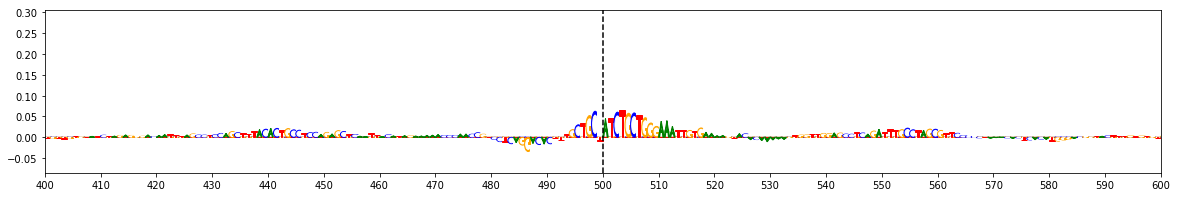

Allele Ratio : 0.3229   ||   Allele Difference : -2.0696  ||  ISM Score : -3.219  ||  deltaSVM Score : -18.55



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 277   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.447   ||   Center / 200bp : 0.6123
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


Effect Allele : C   ||   Explain Score : 0.1815   ||   Center / 200bp : 0.3934
Effect Sequence : CTCAAGACCCCCTCCACTGT


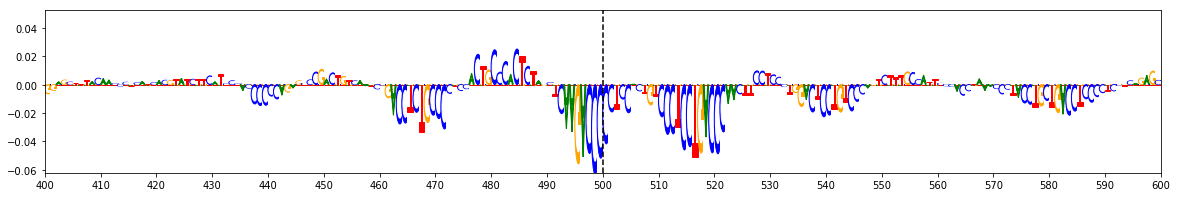

Allele Ratio : 0.4061   ||   Allele Difference : -0.7367  ||  ISM Score : -1.179  ||  deltaSVM Score : -6.7808


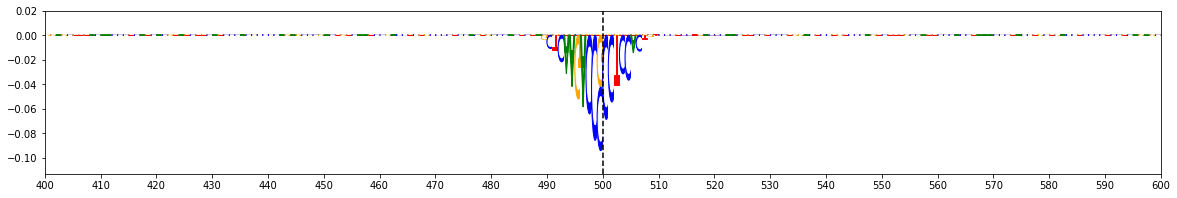


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs935534   ||    chr12 : 33530906 - 33530907   ||    Locus: 44   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.46E-07

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.5268   ||   Center / 200bp : 0.4746
Noneffect Sequence : TTTTGTCTTAGTCAGATGCT


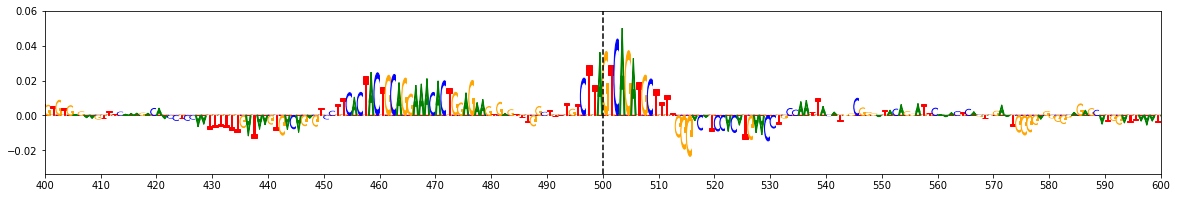

Effect Allele : G   ||   Explain Score : 0.1686   ||   Center / 200bp : 0.2243
Effect Sequence : TTTTGTCTTGGTCAGATGCT


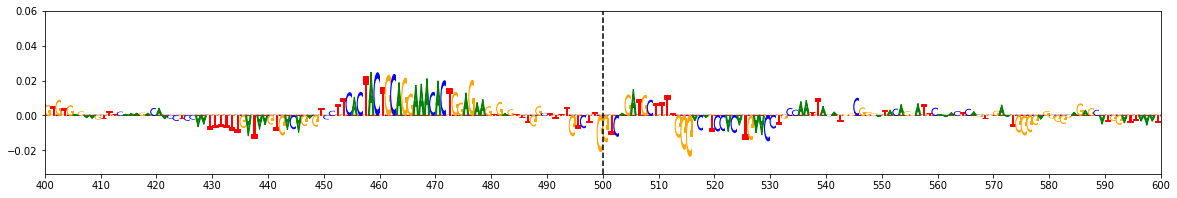

Allele Ratio : 0.3201   ||   Allele Difference : -0.4476  ||  ISM Score : -0.7061  ||  deltaSVM Score : -4.0239


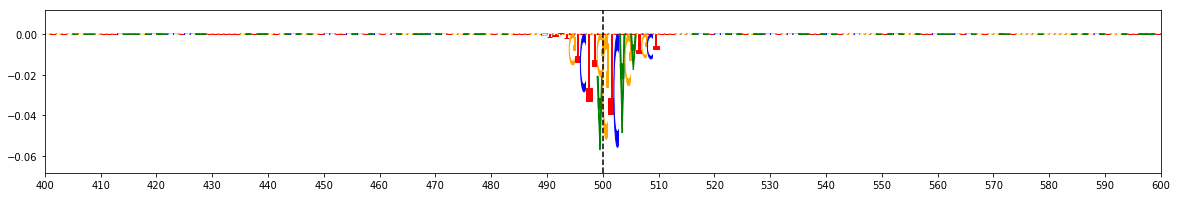


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 424   ||    IDR Peak: False

GWAS:
Alzheimers_Lambert_2013 	  1.99E-07
Alzheimers_Jansen_2018 		  1.31E-11
Alzheimers_Kunkle_2019 		  3.79E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3433   ||   Center / 200bp : 0.6808
Noneffect Sequence : TTCACTGGCCTGTAGGGGGA


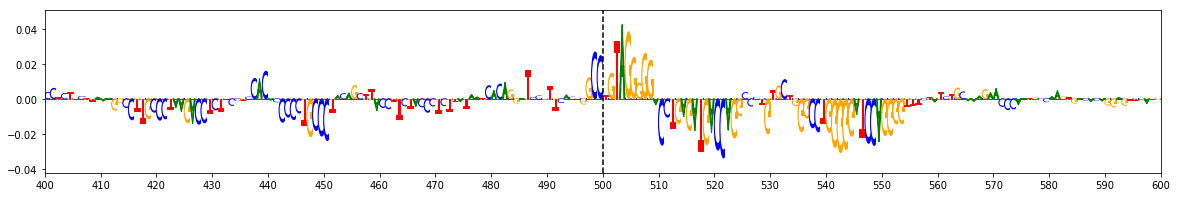

Effect Allele : A   ||   Explain Score : 0.1675   ||   Center / 200bp : 0.5097
Effect Sequence : TTCACTGGCATGTAGGGGGA


Allele Ratio : 0.4877   ||   Allele Difference : -0.1941  ||  ISM Score : -0.303  ||  deltaSVM Score : -1.7326


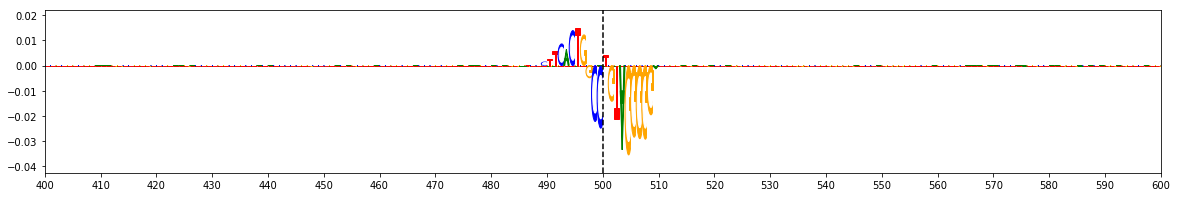


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7218130   ||    chr17 : 4842203 - 4842204   ||    Locus: 89   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  6.27E-04
Alzheimers_Lambert_2013 	  4.67E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3423   ||   Center / 200bp : 0.2605
Noneffect Sequence : GCCTGGGCGGCAGAGCGAGA


Effect Allele : A   ||   Explain Score : 0.0644   ||   Center / 200bp : 0.062
Effect Sequence : GCCTGGGCGACAGAGCGAGA


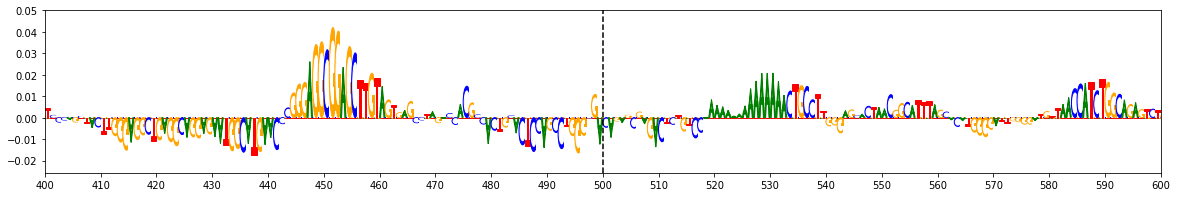

Allele Ratio : 0.1881   ||   Allele Difference : -0.3809  ||  ISM Score : -0.6526  ||  deltaSVM Score : -3.7589


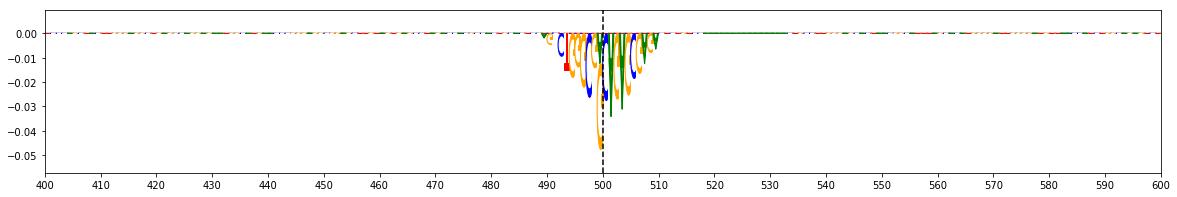


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 392   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.1773   ||   Center / 200bp : 0.591
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


Effect Allele : NAN   ||   Explain Score : 0.5029   ||   Center / 200bp : 0.3798
Effect Sequence : CCAATCAGCCCCTGCCAGAC


Allele Ratio : 0.4271   ||   Allele Difference : -0.8283  ||  ISM Score : -1.2655  ||  deltaSVM Score : -7.5358



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063279   ||    chr17 : 45959569 - 45959570   ||    Locus: 183   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.21E-21

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.1711   ||   Center / 200bp : 0.3808
Noneffect Sequence : ACTTTGGGAAGCCGAGGCAG


Effect Allele : G   ||   Explain Score : 0.0544   ||   Center / 200bp : 0.1639
Effect Sequence : ACTTTGGGAGGCCGAGGCAG


Allele Ratio : 0.3178   ||   Allele Difference : -0.5933  ||  ISM Score : -0.9504  ||  deltaSVM Score : -5.4492



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56118506   ||    chr3 : 122458998 - 122458999   ||    Locus: 336   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  5.45E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.6506   ||   Center / 200bp : 0.5368
Noneffect Sequence : TTATCACTTCCGGAGGAATC


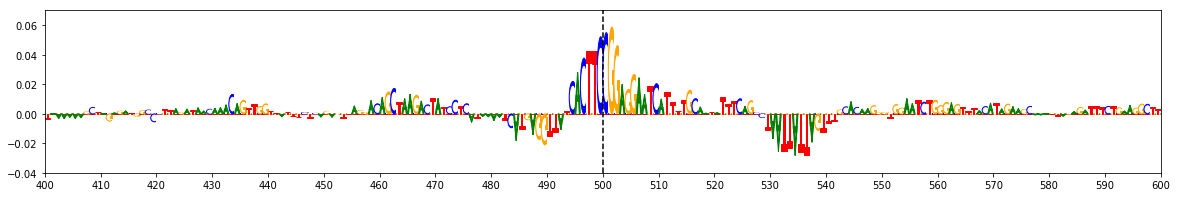

Effect Allele : T   ||   Explain Score : 0.2928   ||   Center / 200bp : 0.3429
Effect Sequence : TTATCACTTTCGGAGGAATC


Allele Ratio : 0.45   ||   Allele Difference : -0.3848  ||  ISM Score : -0.6003  ||  deltaSVM Score : -3.4499


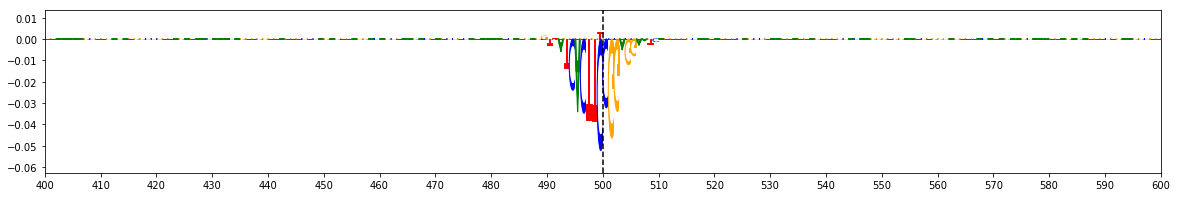


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063292   ||    chr17 : 45966269 - 45966270   ||    Locus: 185   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.30E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8979   ||   Center / 200bp : 0.579
Noneffect Sequence : AAAACTGTTCCAAAATAACA


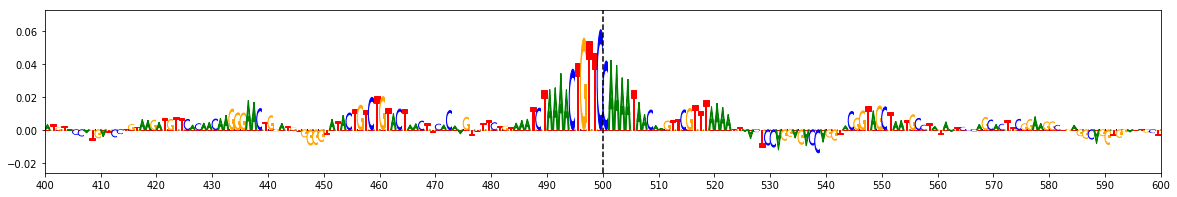

Effect Allele : T   ||   Explain Score : 0.4992   ||   Center / 200bp : 0.4342
Effect Sequence : AAAACTGTTTCAAAATAACA


Allele Ratio : 0.556   ||   Allele Difference : -0.4011  ||  ISM Score : -0.6256  ||  deltaSVM Score : -3.5826


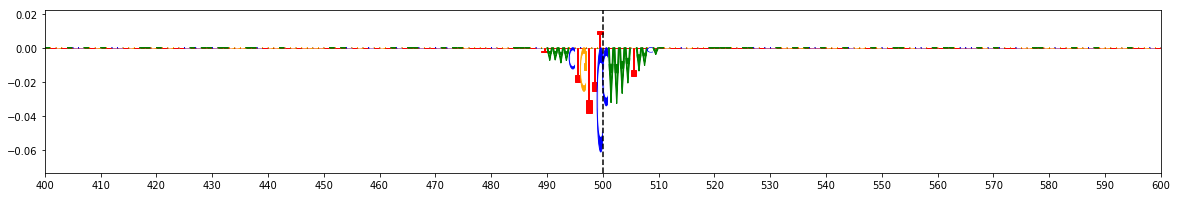


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs118039704   ||    chr17 : 62065536 - 62065537   ||    Locus: 218   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.1777   ||   Center / 200bp : 0.2009
Noneffect Sequence : GACGGAGGGAATGTGTGCCC


Effect Allele : G   ||   Explain Score : 0.0351   ||   Center / 200bp : 0.0474
Effect Sequence : GACGGAGGGGATGTGTGCCC


Allele Ratio : 0.1976   ||   Allele Difference : -0.2093  ||  ISM Score : -0.3387  ||  deltaSVM Score : -1.9333



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 245   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.336   ||   Center / 200bp : 0.4486
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


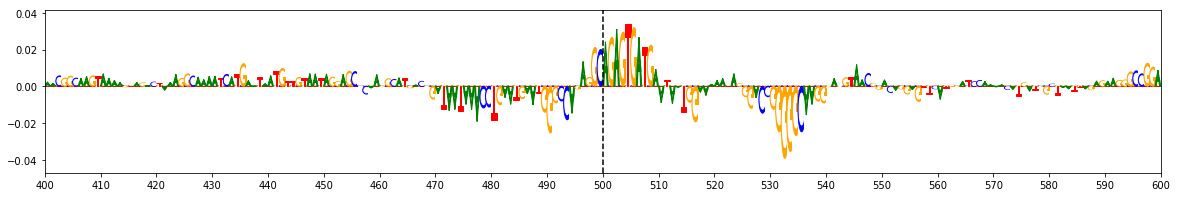

Effect Allele : T   ||   Explain Score : 0.1553   ||   Center / 200bp : 0.2729
Effect Sequence : GGCCAGAGGTAGAGTGATGA


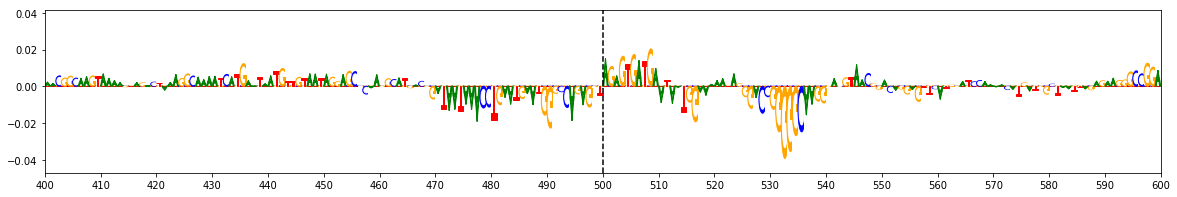

Allele Ratio : 0.4621   ||   Allele Difference : -0.1966  ||  ISM Score : -0.3119  ||  deltaSVM Score : -1.7529


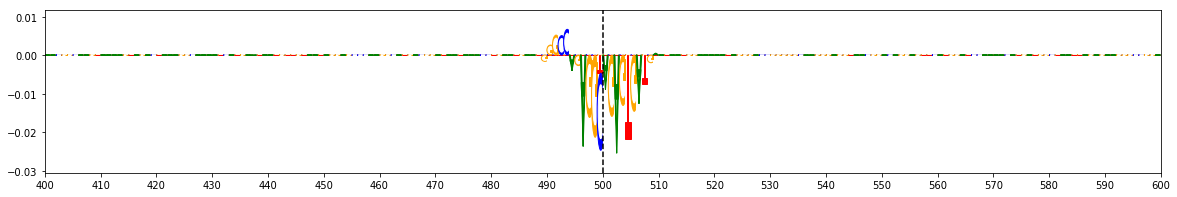


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3733345   ||    chr4 : 960458 - 960459   ||    Locus: 348   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.35E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.9476   ||   Center / 200bp : 0.6268
Noneffect Sequence : GATGAGGGCGGGTCCCGCTC


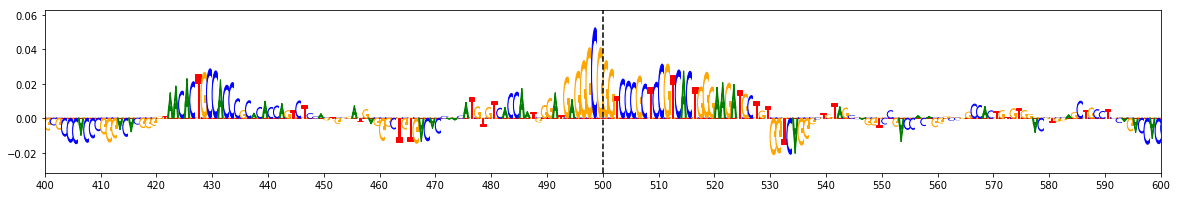

Effect Allele : T   ||   Explain Score : 0.6368   ||   Center / 200bp : 0.5327
Effect Sequence : GATGAGGGCTGGTCCCGCTC


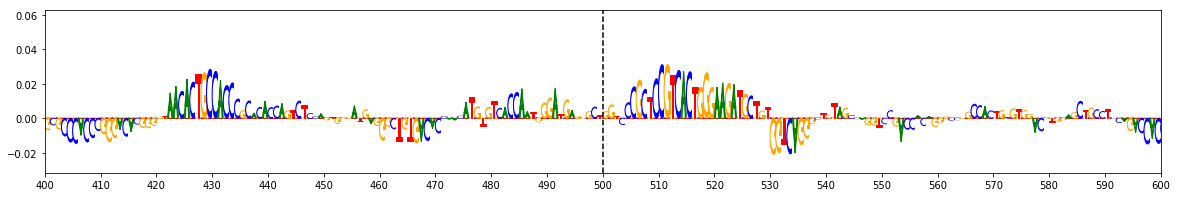

Allele Ratio : 0.672   ||   Allele Difference : -0.3145  ||  ISM Score : -0.4881  ||  deltaSVM Score : -2.8276


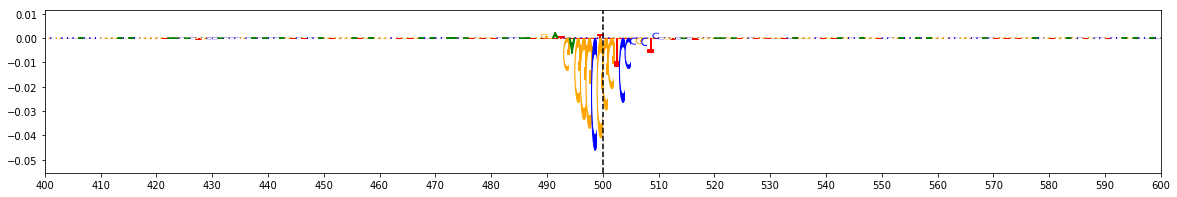


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2737022   ||    chr4 : 89818510 - 89818511   ||    Locus: 382   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  1.53E-07
23andme_PD_hg38 		  5.13E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.2258   ||   Center / 200bp : 0.2793
Noneffect Sequence : GCTCTCTAACACTCCAGAAA


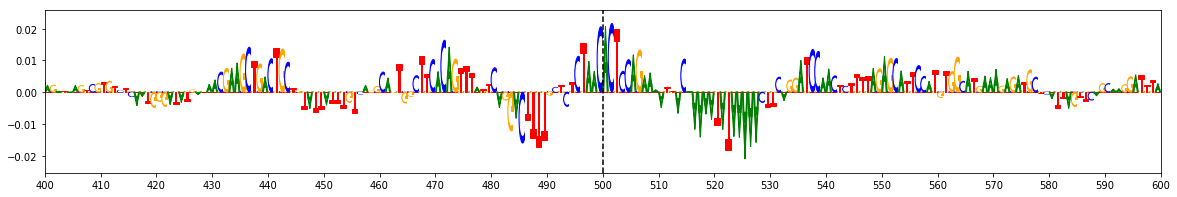

Effect Allele : A   ||   Explain Score : 0.0688   ||   Center / 200bp : 0.1059
Effect Sequence : GCTCTCTAAAACTCCAGAAA


Allele Ratio : 0.3047   ||   Allele Difference : -0.184  ||  ISM Score : -0.2873  ||  deltaSVM Score : -1.6419


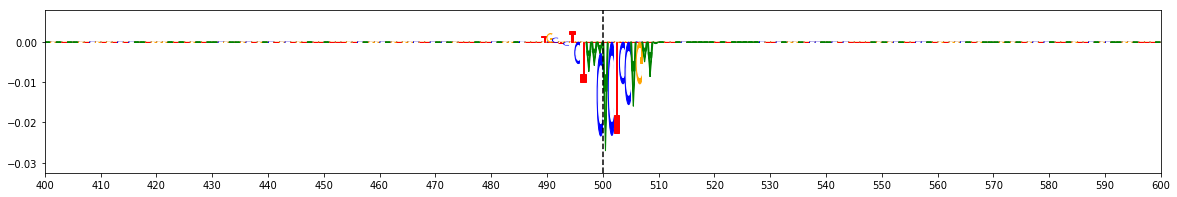


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 145   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.9765   ||   Center / 200bp : 0.847
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


Effect Allele : C   ||   Explain Score : 2.8562   ||   Center / 200bp : 0.8416
Effect Sequence : TTGAATGCTCCTGTGCTGCC


Allele Ratio : 0.9596   ||   Allele Difference : -0.1328  ||  ISM Score : -0.2082  ||  deltaSVM Score : -1.2171


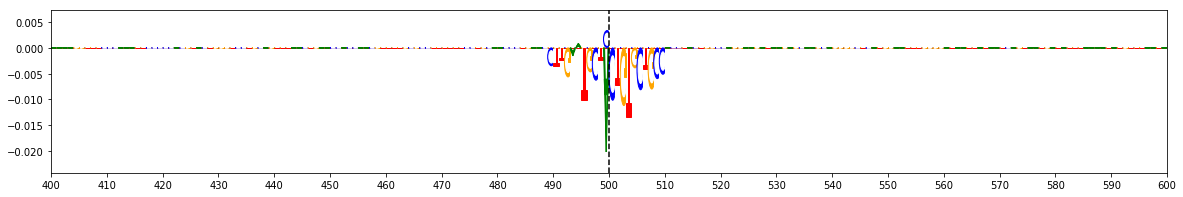


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 151   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6376   ||   Center / 200bp : 0.5824
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


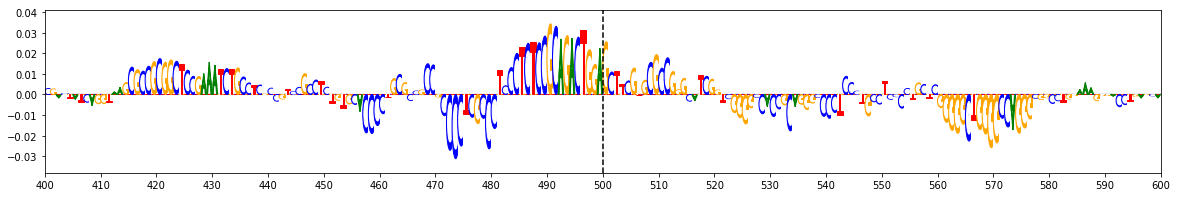

Effect Allele : G   ||   Explain Score : 0.4222   ||   Center / 200bp : 0.4803
Effect Sequence : GCAGACTGGGGCTTCGTGCG


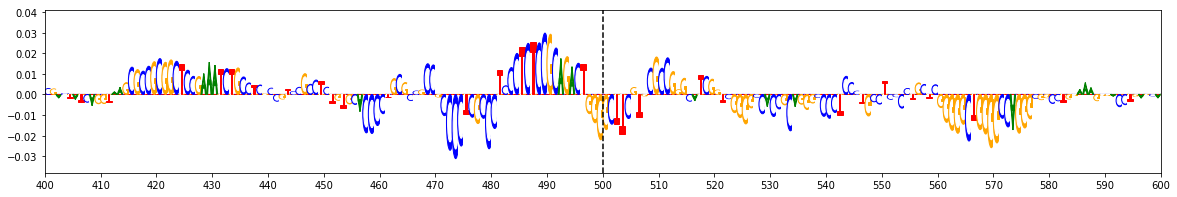

Allele Ratio : 0.6622   ||   Allele Difference : -0.3481  ||  ISM Score : -0.559  ||  deltaSVM Score : -3.2096


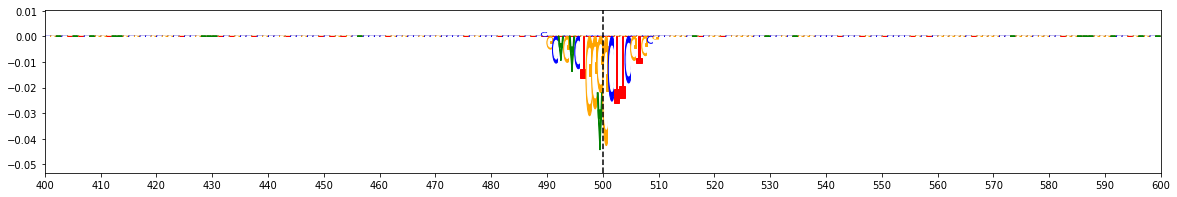


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8180214   ||    chr4 : 89723356 - 89723357   ||    Locus: 369   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.06E-18

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.4968   ||   Center / 200bp : 0.5245
Noneffect Sequence : ATTCAAATCAGACACTATCT


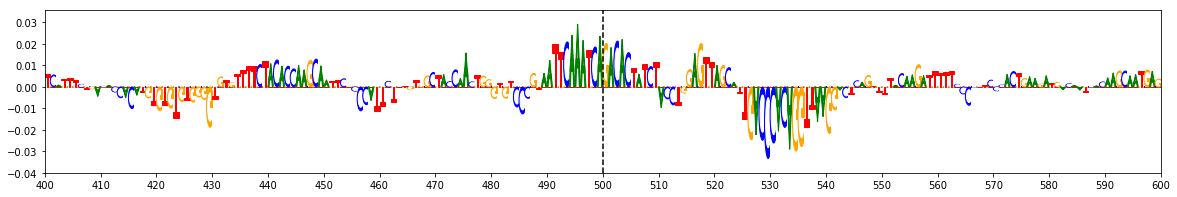

Effect Allele : G   ||   Explain Score : 0.2968   ||   Center / 200bp : 0.3971
Effect Sequence : ATTCAAATCGGACACTATCT


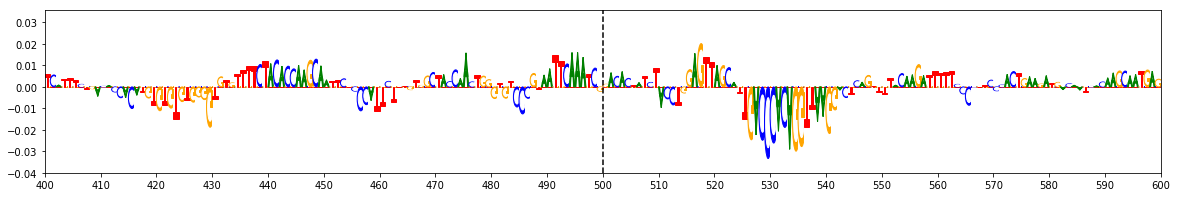

Allele Ratio : 0.5974   ||   Allele Difference : -0.2021  ||  ISM Score : -0.3159  ||  deltaSVM Score : -1.8254


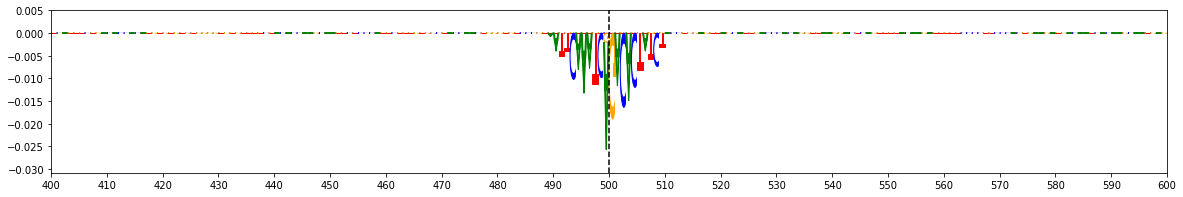


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7759217   ||    chr6 : 27762683 - 27762684   ||    Locus: 410   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  2.64E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.0357   ||   Center / 200bp : 0.7253
Noneffect Sequence : ACAGCGCAGATAGGGTTGTT


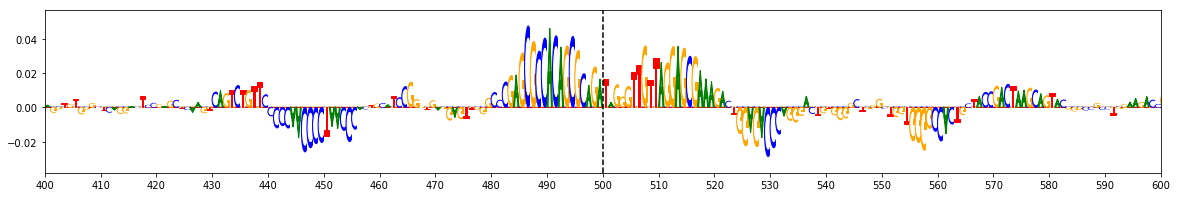

Effect Allele : G   ||   Explain Score : 0.8626   ||   Center / 200bp : 0.6874
Effect Sequence : ACAGCGCAGGTAGGGTTGTT


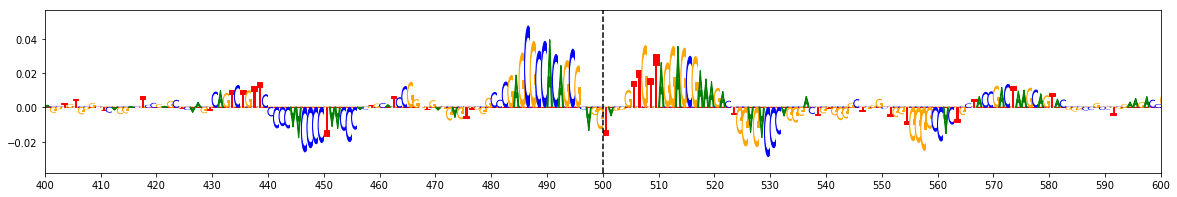

Allele Ratio : 0.8329   ||   Allele Difference : -0.229  ||  ISM Score : -0.3581  ||  deltaSVM Score : -2.0654


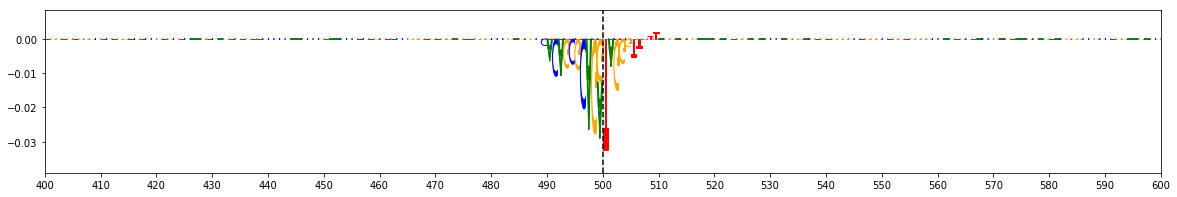


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 398   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.5835   ||   Center / 200bp : 0.7638
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


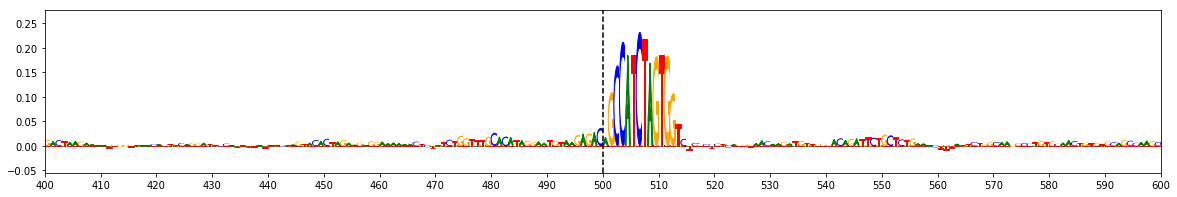

Effect Allele : T   ||   Explain Score : 2.2923   ||   Center / 200bp : 0.7418
Effect Sequence : TGTAAGAGATAGCCATCTAG


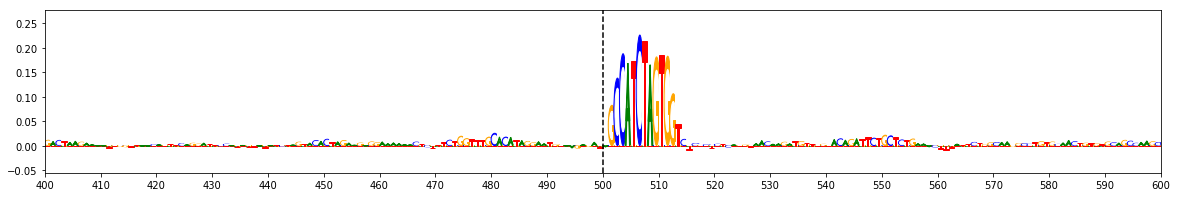

Allele Ratio : 0.8873   ||   Allele Difference : -0.3107  ||  ISM Score : -0.4883  ||  deltaSVM Score : -2.7709


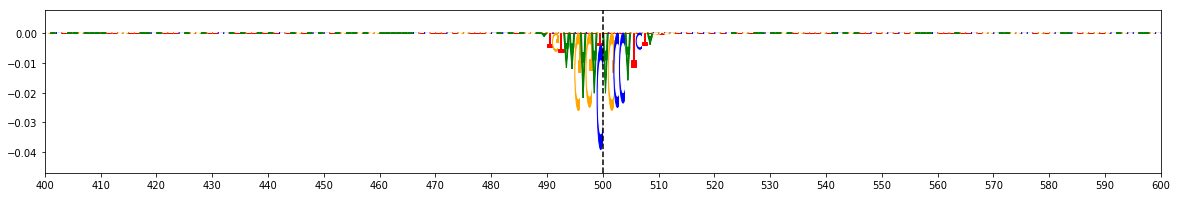


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17016188   ||    chr4 : 89800728 - 89800729   ||    Locus: 380   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.12E-12

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.7354   ||   Center / 200bp : 0.6588
Noneffect Sequence : TGGAGAAGACGAATTGTACT


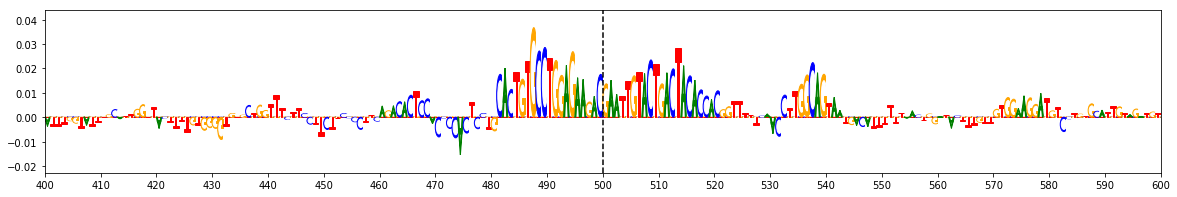

Effect Allele : T   ||   Explain Score : 0.5745   ||   Center / 200bp : 0.6014
Effect Sequence : TGGAGAAGATGAATTGTACT


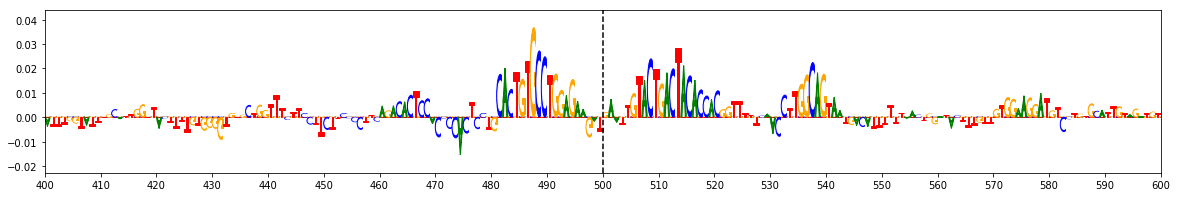

Allele Ratio : 0.7812   ||   Allele Difference : -0.1812  ||  ISM Score : -0.283  ||  deltaSVM Score : -1.6423


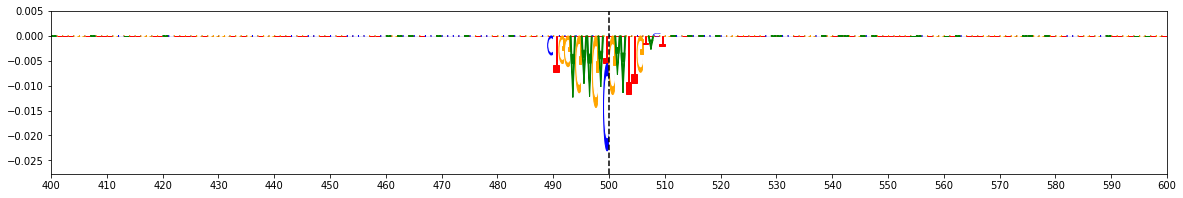


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7218117   ||    chr17 : 4842178 - 4842179   ||    Locus: 87   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.33E-03
Alzheimers_Lambert_2013 	  1.02E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.74   ||   Center / 200bp : 0.5886
Noneffect Sequence : GCCTAGACCGCGCCACTGCA


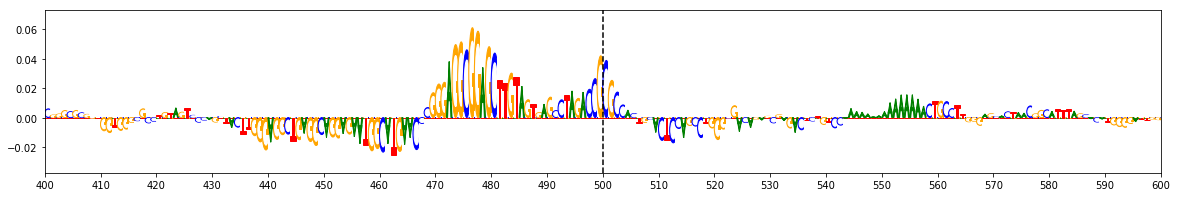

Effect Allele : A   ||   Explain Score : 0.5199   ||   Center / 200bp : 0.5014
Effect Sequence : GCCTAGACCACGCCACTGCA


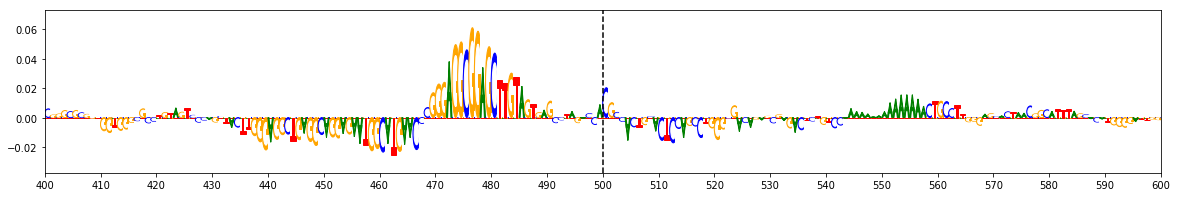

Allele Ratio : 0.7027   ||   Allele Difference : -0.2604  ||  ISM Score : -0.4291  ||  deltaSVM Score : -2.4689


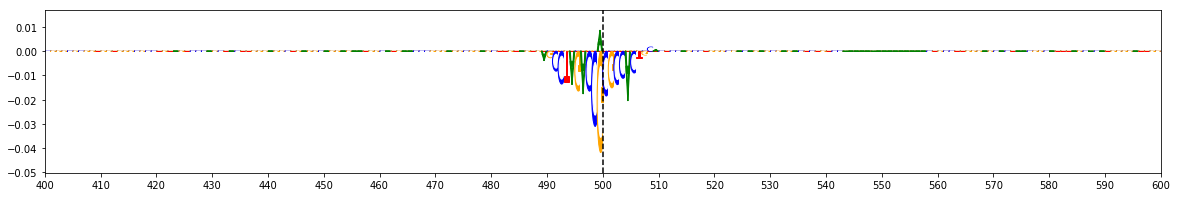


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
160  chr17   45896863   45896864   rs62056782      T         C   C    T     C   
332   chr3   52498433   52498434  rs181391313      G         A   G    A     G   
252  chr19   44954309   44954310    rs7245611      C         T   T  C,G     C   
76   chr16   31009756   31009757    rs7184567      T         C   C    T     C   
199  chr17   46038519   46038520   rs12150090      T         C   C  G,T     C   
184  chr17   45966011   45966012   rs62063291      T         C   T    C     T   
403   chr5  103228475  103228476     rs246908      G         A   G    A     G   
406   chr5  134594837  134594838   rs17167632      G         A   G    A     G   
15   chr10   80493944   80493945    rs7900536      A         C   C  A,T     A   
337   chr3  122459017  122459018   rs55793255      G         A   A    G     A   
347   chr4     959909     959910    rs4690326      C         A   A    C     C   
405   chr5  134594466  134594467  rs113661575      G         C   G  A,C     G   
268  chr19   45039212   45039213   rs34034621      T         C   C    T     C   
293   chr2  127084806  127084807   rs11691237      T         C   C    T     C   
306   chr2  134719288  134719289   rs62171396      T         C   C    T     C   
34   chr11   60251687   60251688     rs636341      A         C   A    C     C   
162  chr17   45897109   45897110   rs80346216      T         G   G    T     G   
17   chr10  102245652  102245653    rs2296887      T         C   T    C     T   
171  chr17   45909065   45909066   rs12150125      G         A   G  A,T     G   
212  chr17   46213392   46213393    rs2668662      T         C   T    C     T   
216  chr17   46771150   46771151     rs199523      C         A   C    A     A   
182  chr17   45959547   45959548   rs62063278      T         C   C    T     C   
394   chr4   90290372   90290373   rs75541595      G         A   G    A     G   
279   chr2   95076932   95076933    rs3105101      C         A   C    A     A   
66   chr16   30010080   30010081    rs1140239    NAN       NAN   C  A,T     C   
135  chr17   45747972   45747973   rs62054435      G         C   C    G     C   
366   chr4   89723193   89723194   rs79596632      G         A   G    A     G   
272  chr19   45130427   45130428     rs754366      A         G   G    A     G   
381   chr4   89818353   89818354    rs2737023      T         C   T    C     T   
397   chr5  102910380  102910381   rs35100629      G         C   C    G     C   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
318   chr3   48919428   48919429    rs9884022      G         C   G  C,T     C   
339   chr4     875380     875381   rs11733713    NAN       NAN   A    G     A   
365   chr4   89723129   89723130   rs17016071      G         A   A    G     A   
407   chr5  134600503  134600504  rs142547906      G         A   G    A     G   
164  chr17   45897182   45897183   rs62056783      G         C   G    C     G   
411   chr6   47477280   47477281    rs1004173      T         C   C    T     C   
352   chr4     973656     973657   rs13137144      G         A   G  A,C     G   
409   chr6   27762284   27762285    rs9295746      T         C   T    C     T   
0     chr1  155135690  155135691   rs12726330      G         A   G  A,C     G   
434   chr9   17730966   17730967   rs10810837      T         C   T    C     T   
168  chr17   45908295   45908296   rs79290980      T         C   T    C     T   
189  chr17   45997246   45997247   rs62063853      G         A   A    G     A   
74   chr16   30958235   30958236   rs62055866      G         C   G    C     C   
140  chr17   45748358   45748359   rs62054439      T         G   G    T     G   
158  chr17   45896131   45896132    rs4792891      T         G   T    G     T   
357   chr4   18022407   18022408    rs1380295      G         C   C  A,G     C   
412   chr6  132812798  132812799   rs79333841      G         C   C  G,T     C   
201  chr17   46038945   46038946   rs6

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 160   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.5448   ||  Center / 200bp: 0.7128
Effect Sequence: CTCGCCCTCTTGTGATGAAC


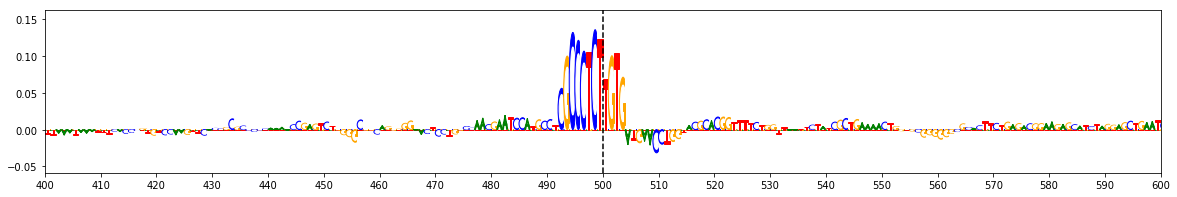

Noneffect Allele: C   ||  Explain Score: 0.6061   ||  Center / 200bp: 0.4934
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


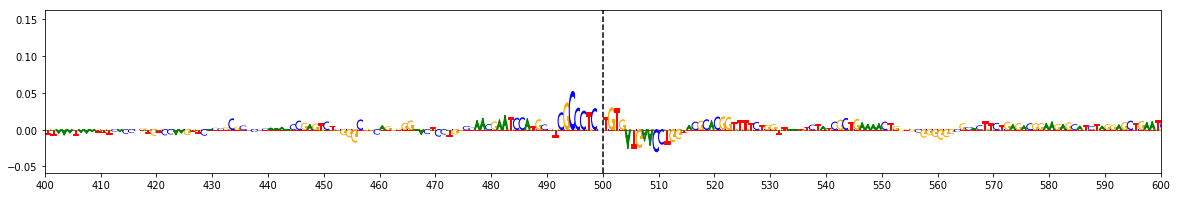

Allele Ratio : 2.5489   ||   Allele Difference : 0.9701  ||  ISM Score : 1.515  ||  deltaSVM Score : 8.7245


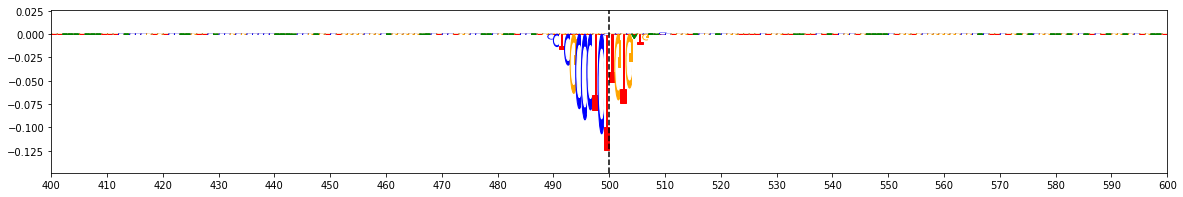


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 332   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.339   ||  Center / 200bp: 0.2494
Effect Sequence: CCATGGGGCGGAGGCAGGGC


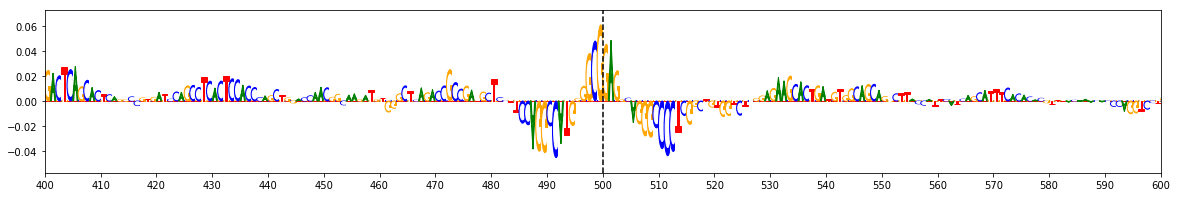

Noneffect Allele: A   ||  Explain Score: 0.0557   ||  Center / 200bp: 0.0518
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


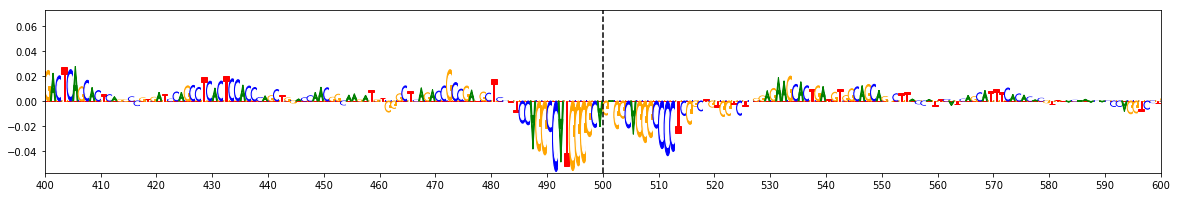

Allele Ratio : 6.0823   ||   Allele Difference : 0.6453  ||  ISM Score : 1.0091  ||  deltaSVM Score : 5.791


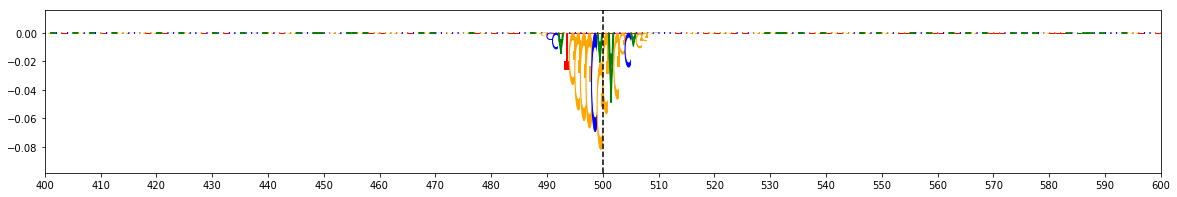


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7245611   ||    chr19 : 44954309 - 44954310   ||    Locus: 252   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  6.09E-12
Alzheimers_Lambert_2013 	  4.58E-11

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.4317   ||  Center / 200bp: 0.5199
Effect Sequence: GTGGTGGCGCGCTCCTGTAA


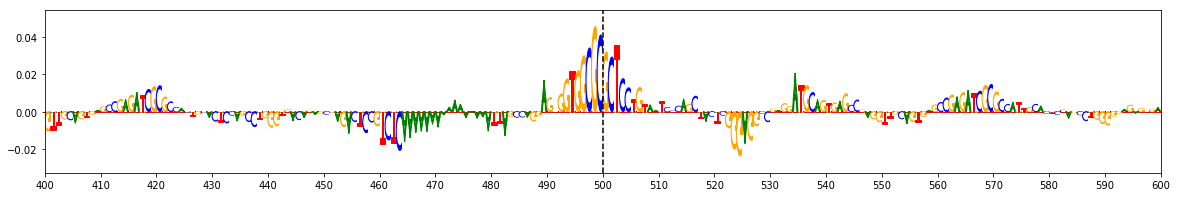

Noneffect Allele: T   ||  Explain Score: 0.1752   ||  Center / 200bp: 0.3049
Noneffect Sequence: GTGGTGGCGTGCTCCTGTAA


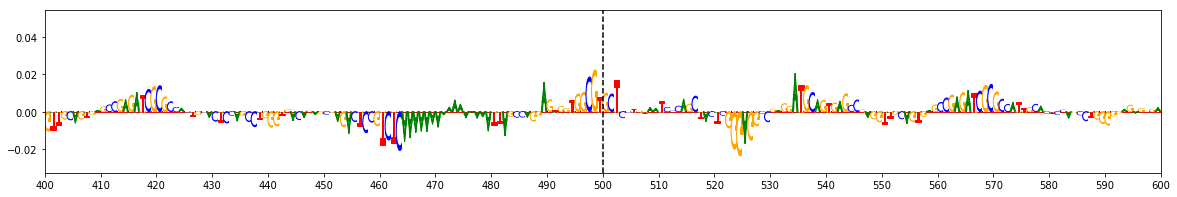

Allele Ratio : 2.4643   ||   Allele Difference : 0.2604  ||  ISM Score : 0.5201  ||  deltaSVM Score : 2.9836


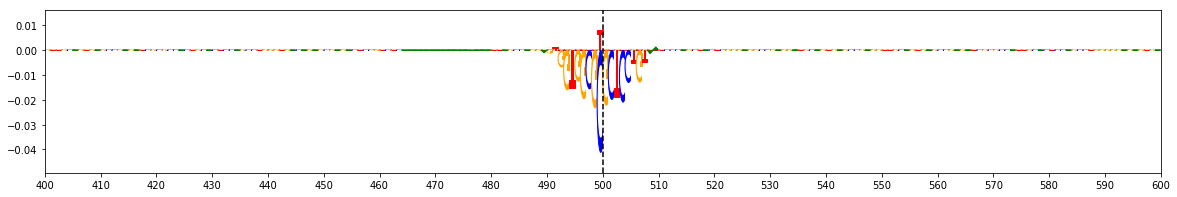


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7184567   ||    chr16 : 31009756 - 31009757   ||    Locus: 76   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.10E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.1698   ||  Center / 200bp: 0.3372
Effect Sequence: TCTGCATCCTCATCTCCCAC


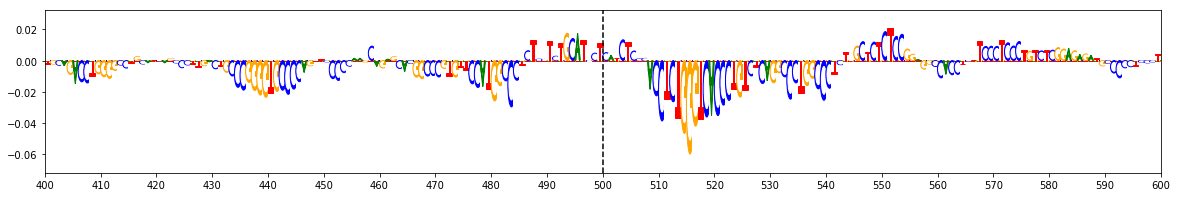

Noneffect Allele: C   ||  Explain Score: 0.0448   ||  Center / 200bp: 0.1186
Noneffect Sequence: TCTGCATCCCCATCTCCCAC


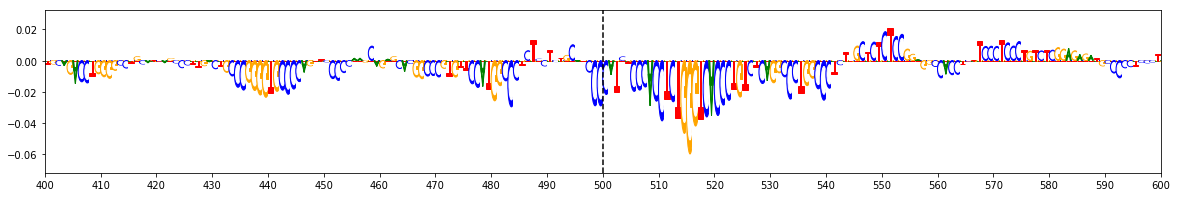

Allele Ratio : 3.7856   ||   Allele Difference : 0.3174  ||  ISM Score : 0.5072  ||  deltaSVM Score : 2.9731


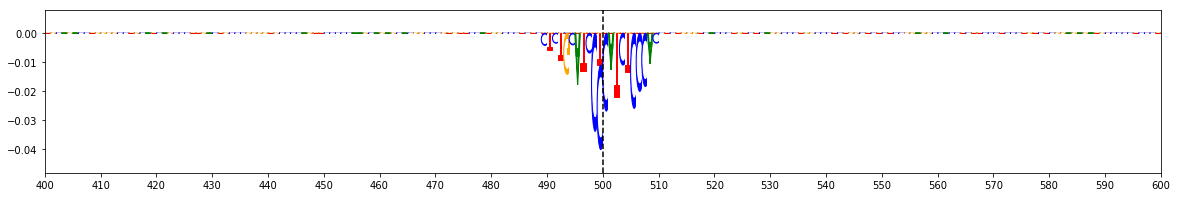


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 199   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.06E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5931   ||  Center / 200bp: 0.4125
Effect Sequence: TCCGGCCAATCCCACACAGG


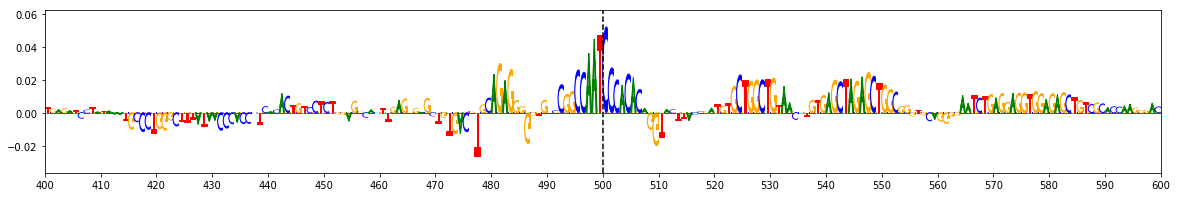

Noneffect Allele: C   ||  Explain Score: 0.1956   ||  Center / 200bp: 0.1884
Noneffect Sequence: TCCGGCCAACCCCACACAGG


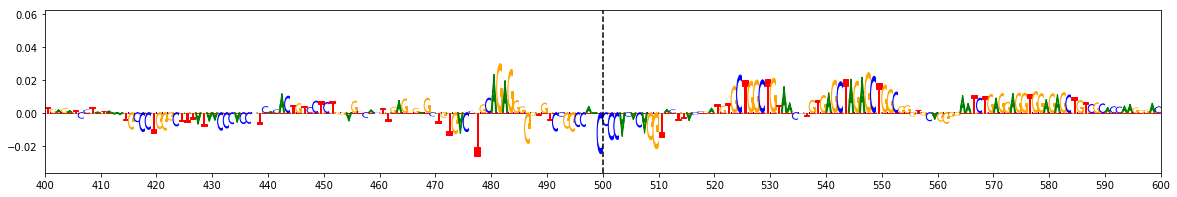

Allele Ratio : 3.0316   ||   Allele Difference : 0.5695  ||  ISM Score : 0.8894  ||  deltaSVM Score : 5.1632


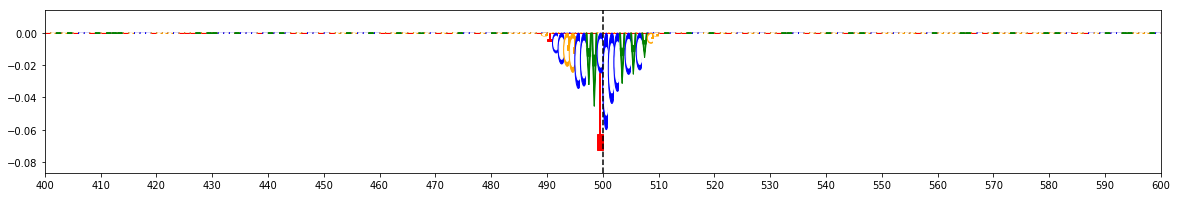


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063291   ||    chr17 : 45966011 - 45966012   ||    Locus: 184   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.30E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3313   ||  Center / 200bp: 0.3981
Effect Sequence: CCACCAAGCTCCCTTGGAAC


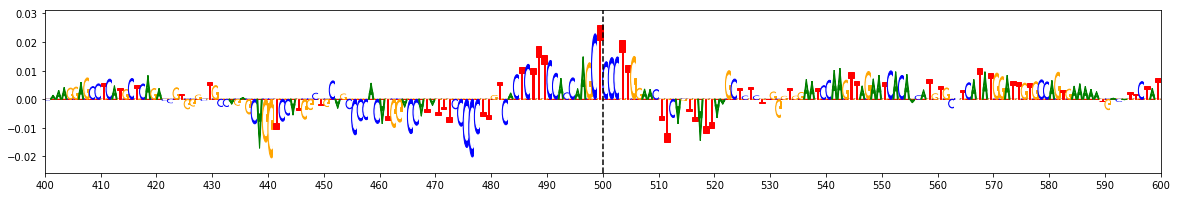

Noneffect Allele: C   ||  Explain Score: 0.1118   ||  Center / 200bp: 0.1818
Noneffect Sequence: CCACCAAGCCCCCTTGGAAC


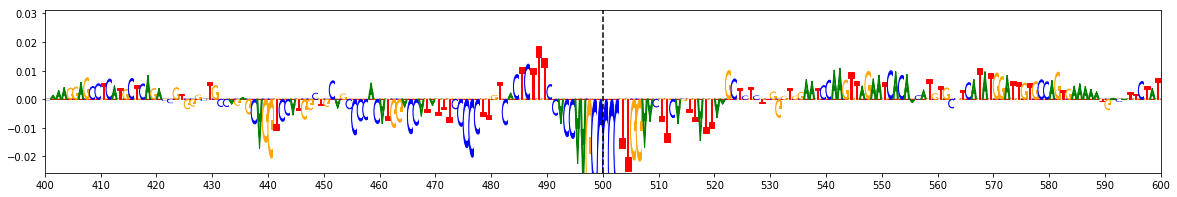

Allele Ratio : 2.9642   ||   Allele Difference : 0.6841  ||  ISM Score : 1.0694  ||  deltaSVM Score : 6.1583


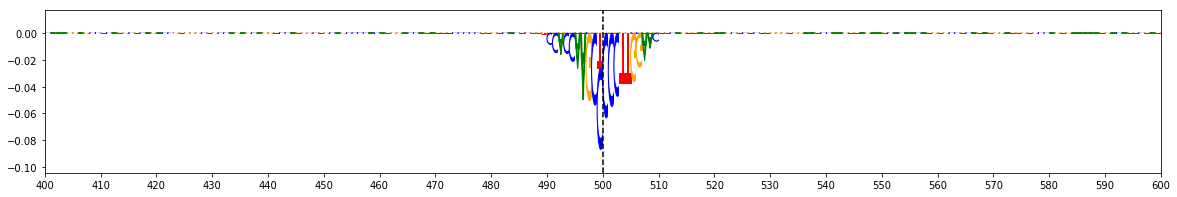


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs246908   ||    chr5 : 103228475 - 103228476   ||    Locus: 403   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  7.77E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4688   ||  Center / 200bp: 0.5699
Effect Sequence: AAACAGAATGTTAAAACAAA


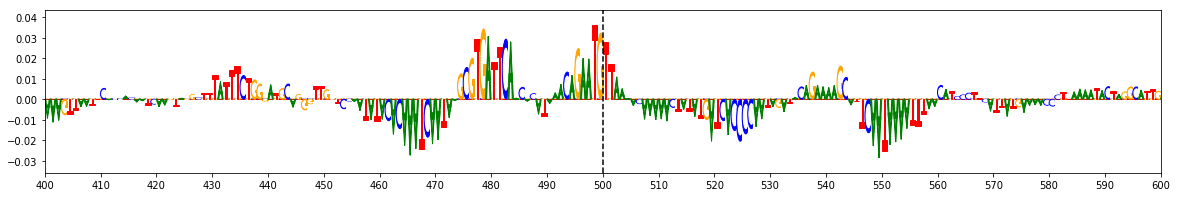

Noneffect Allele: A   ||  Explain Score: 0.2445   ||  Center / 200bp: 0.4088
Noneffect Sequence: AAACAGAATATTAAAACAAA


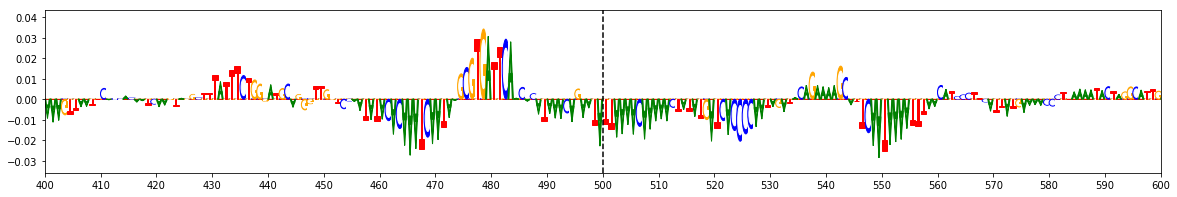

Allele Ratio : 1.9174   ||   Allele Difference : 0.4334  ||  ISM Score : 0.6786  ||  deltaSVM Score : 3.9329


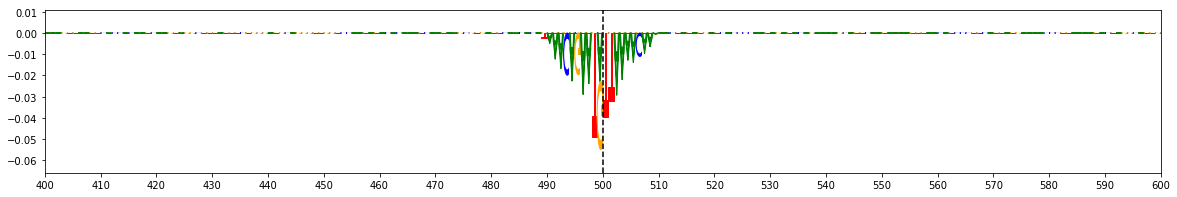


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17167632   ||    chr5 : 134594837 - 134594838   ||    Locus: 406   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.15E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3719   ||  Center / 200bp: 0.5615
Effect Sequence: TCTACCTTGGCTTGGAAAAC


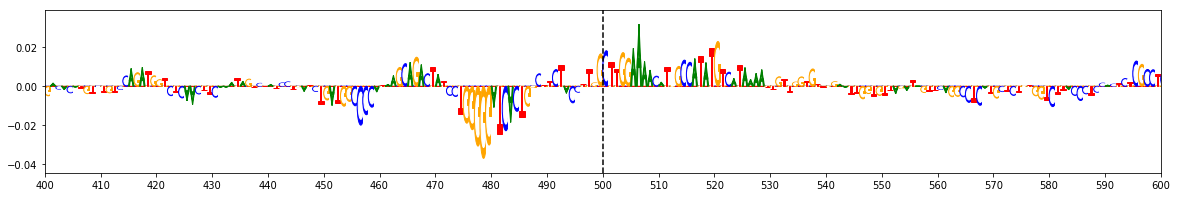

Noneffect Allele: A   ||  Explain Score: 0.1979   ||  Center / 200bp: 0.4052
Noneffect Sequence: TCTACCTTGACTTGGAAAAC


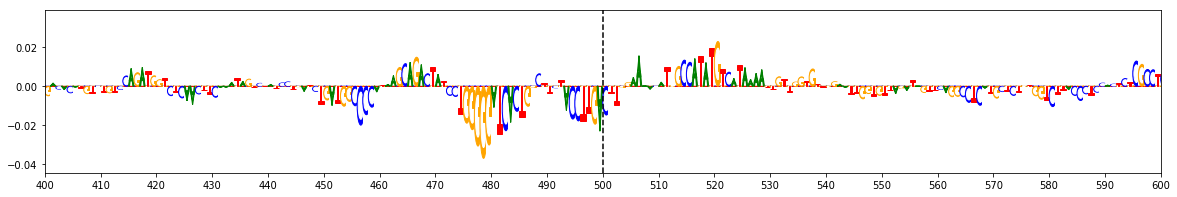

Allele Ratio : 1.8796   ||   Allele Difference : 0.3146  ||  ISM Score : 0.4902  ||  deltaSVM Score : 2.8554



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 15   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.91E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.4325   ||  Center / 200bp: 0.6684
Effect Sequence: GGATGATTCAGATAATGTCT


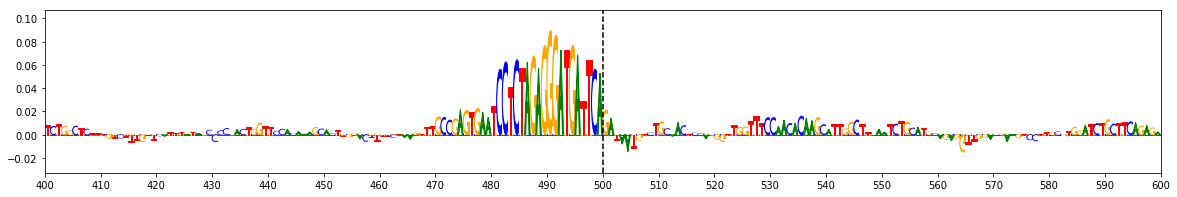

Noneffect Allele: C   ||  Explain Score: 0.9941   ||  Center / 200bp: 0.5829
Noneffect Sequence: GGATGATTCCGATAATGTCT


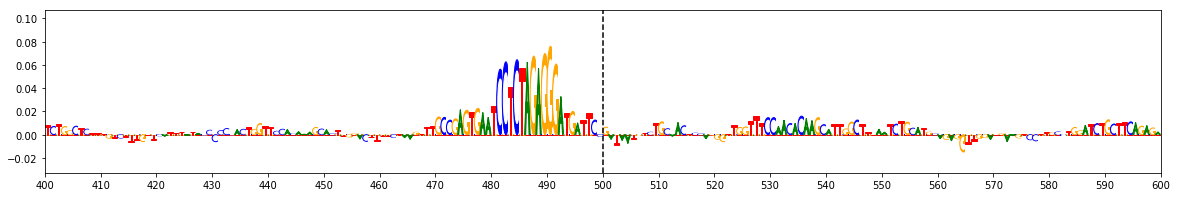

Allele Ratio : 1.4411   ||   Allele Difference : 0.4261  ||  ISM Score : 0.6631  ||  deltaSVM Score : 3.961


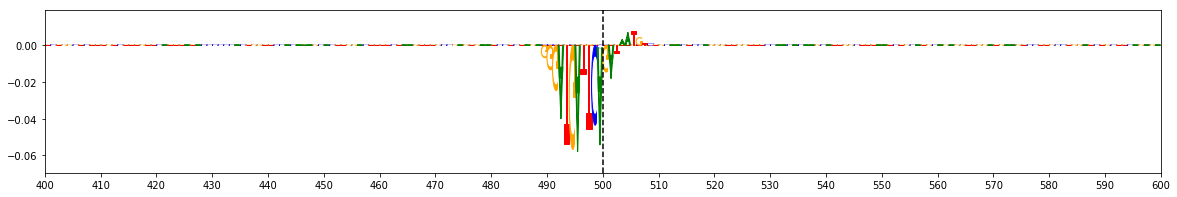


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55793255   ||    chr3 : 122459017 - 122459018   ||    Locus: 337   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  5.44E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.912   ||  Center / 200bp: 0.5985
Effect Sequence: CATTTTGCAGTATTTCAGCC


Noneffect Allele: A   ||  Explain Score: 0.5889   ||  Center / 200bp: 0.4911
Noneffect Sequence: CATTTTGCAATATTTCAGCC


Allele Ratio : 1.5485   ||   Allele Difference : 0.3222  ||  ISM Score : 0.5015  ||  deltaSVM Score : 2.874



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4690326   ||    chr4 : 959909 - 959910   ||    Locus: 347   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.53E-10

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5894   ||  Center / 200bp: 0.5161
Effect Sequence: CTCCTCCCCCAGCAGAGGCA


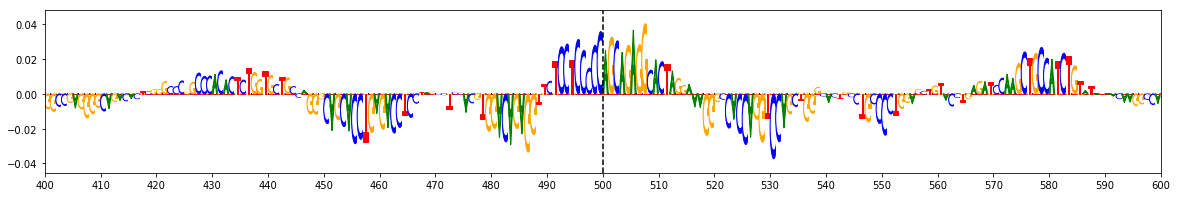

Noneffect Allele: A   ||  Explain Score: 0.3291   ||  Center / 200bp: 0.3729
Noneffect Sequence: CTCCTCCCCAAGCAGAGGCA


Allele Ratio : 1.7909   ||   Allele Difference : 0.2607  ||  ISM Score : 0.413  ||  deltaSVM Score : 2.4074


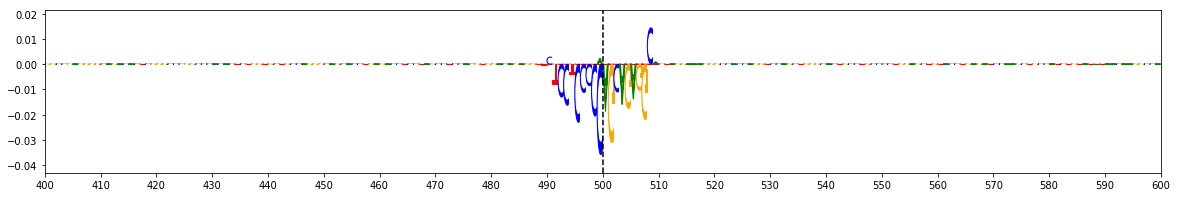


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113661575   ||    chr5 : 134594466 - 134594467   ||    Locus: 405   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.40E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6298   ||  Center / 200bp: 0.5897
Effect Sequence: CTCAGCCTCGCAAAGTGCTG


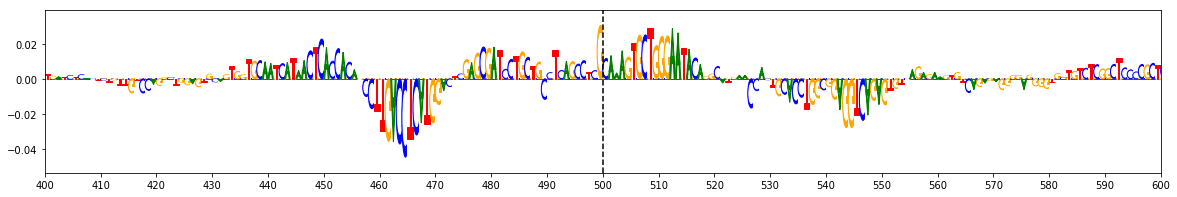

Noneffect Allele: C   ||  Explain Score: 0.4088   ||  Center / 200bp: 0.4838
Noneffect Sequence: CTCAGCCTCCCAAAGTGCTG


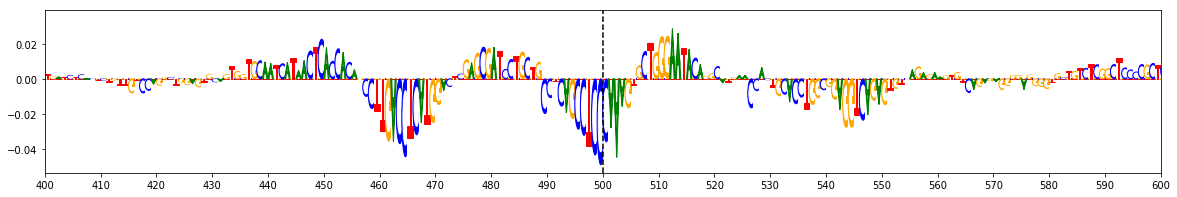

Allele Ratio : 1.5405   ||   Allele Difference : 0.6366  ||  ISM Score : 1.1058  ||  deltaSVM Score : 6.3934


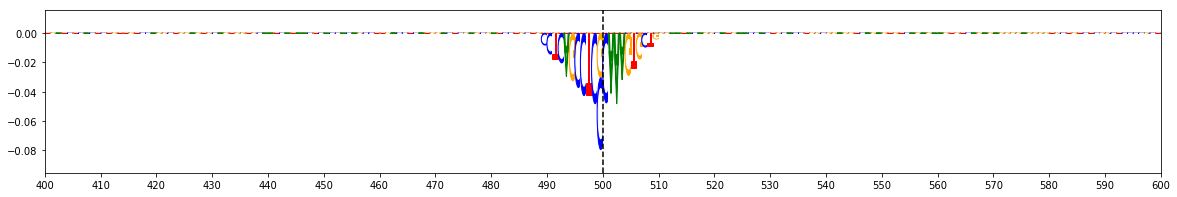


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 268   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5819   ||  Center / 200bp: 0.4579
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


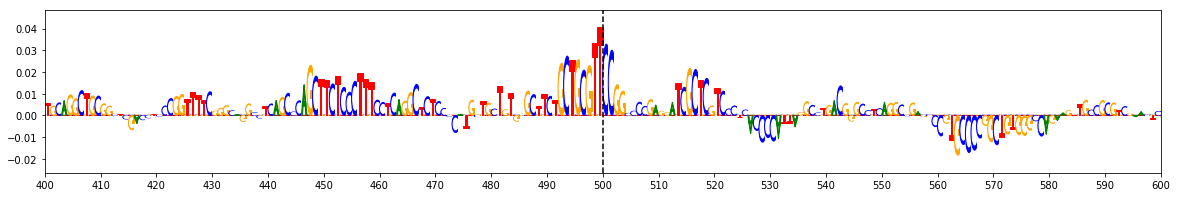

Noneffect Allele: C   ||  Explain Score: 0.3086   ||  Center / 200bp: 0.3097
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


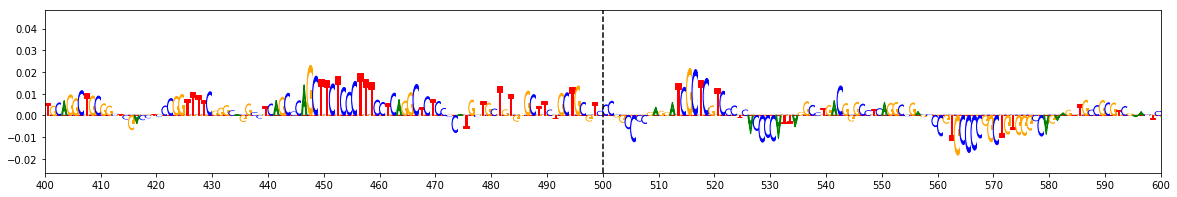

Allele Ratio : 1.8857   ||   Allele Difference : 0.306  ||  ISM Score : 0.4839  ||  deltaSVM Score : 2.8131


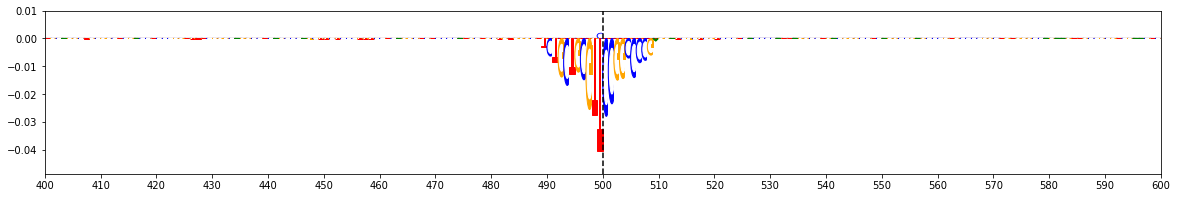


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11691237   ||    chr2 : 127084806 - 127084807   ||    Locus: 293   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.22E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7813   ||  Center / 200bp: 0.6209
Effect Sequence: CTCTGAGCCTATTGCAGTGT


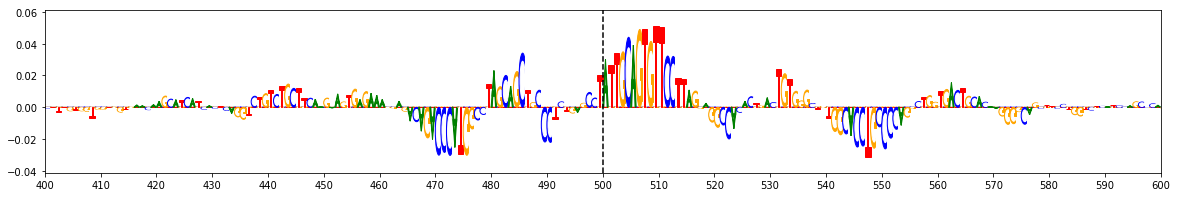

Noneffect Allele: C   ||  Explain Score: 0.571   ||  Center / 200bp: 0.545
Noneffect Sequence: CTCTGAGCCCATTGCAGTGT


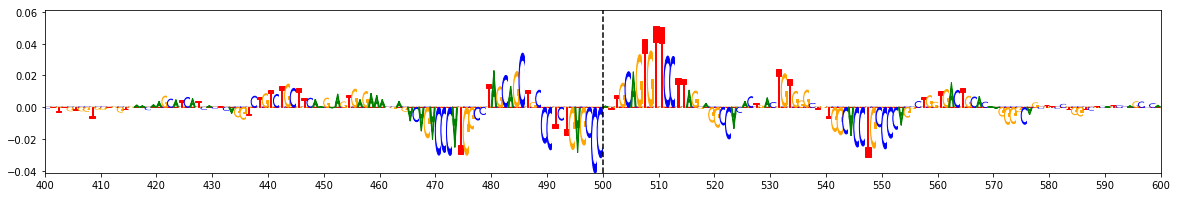

Allele Ratio : 1.3682   ||   Allele Difference : 0.4095  ||  ISM Score : 0.643  ||  deltaSVM Score : 3.7031


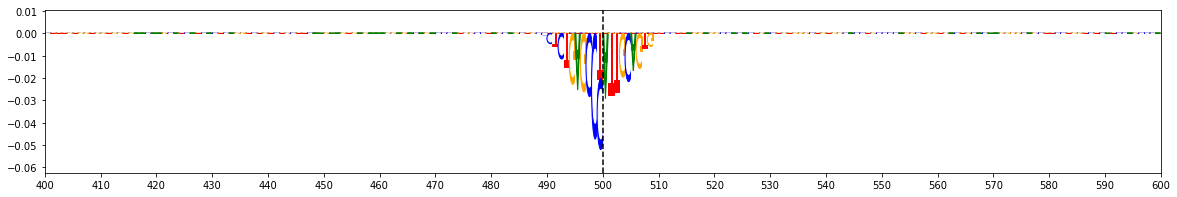


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 306   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7833   ||  Center / 200bp: 0.452
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


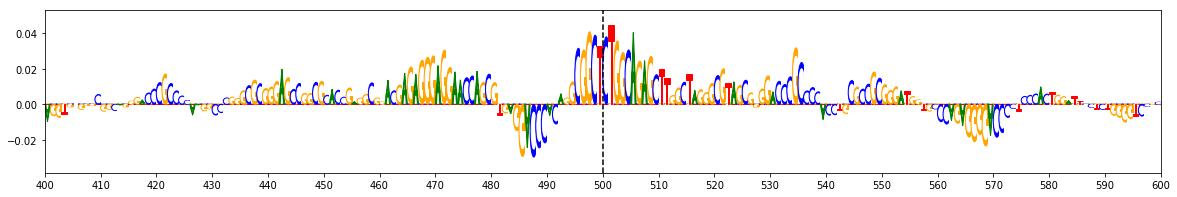

Noneffect Allele: C   ||  Explain Score: 0.4281   ||  Center / 200bp: 0.3096
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


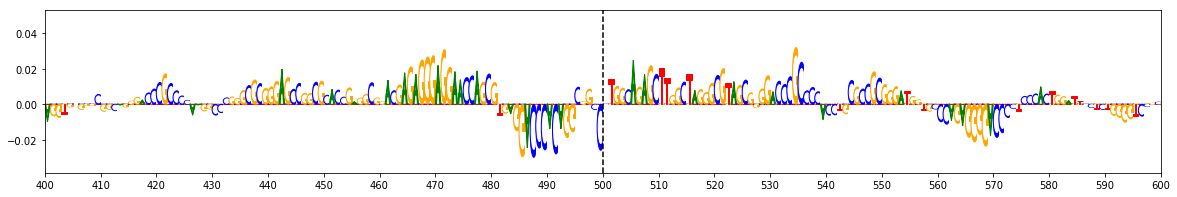

Allele Ratio : 1.8299   ||   Allele Difference : 0.4615  ||  ISM Score : 0.7383  ||  deltaSVM Score : 4.285


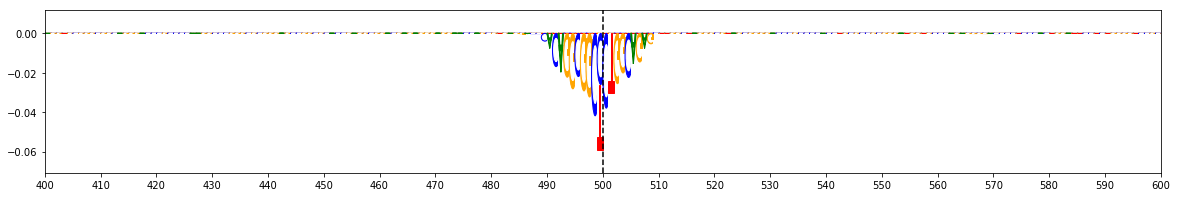


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636341   ||    chr11 : 60251687 - 60251688   ||    Locus: 34   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  3.24E-13
Alzheimers_Kunkle_2019 		  4.96E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Effect Allele: A   ||  Explain Score: 2.7636   ||  Center / 200bp: 0.7414
Effect Sequence: TCTGCTGGGAAATTGTGAAA


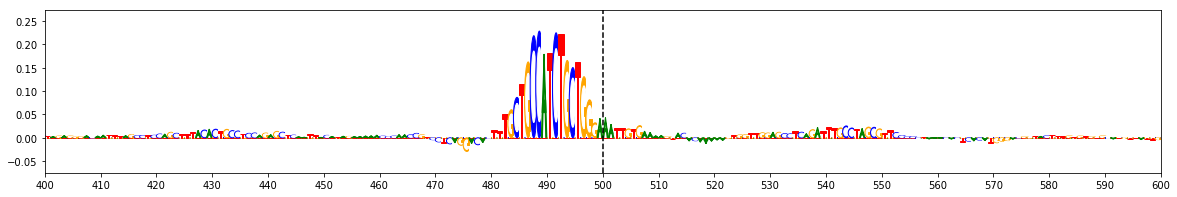

Noneffect Allele: C   ||  Explain Score: 2.5192   ||  Center / 200bp: 0.7234
Noneffect Sequence: TCTGCTGGGCAATTGTGAAA


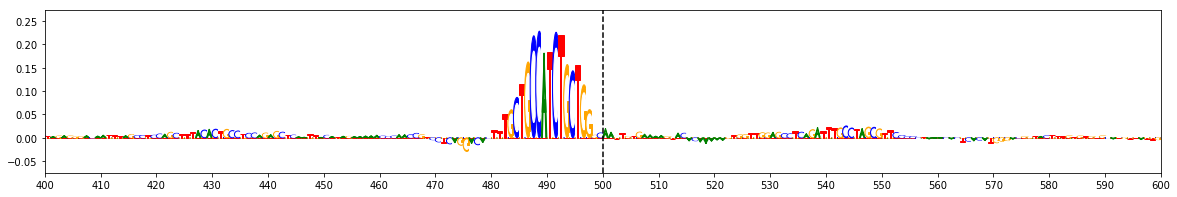

Allele Ratio : 1.097   ||   Allele Difference : 0.2471  ||  ISM Score : 0.383  ||  deltaSVM Score : 2.186


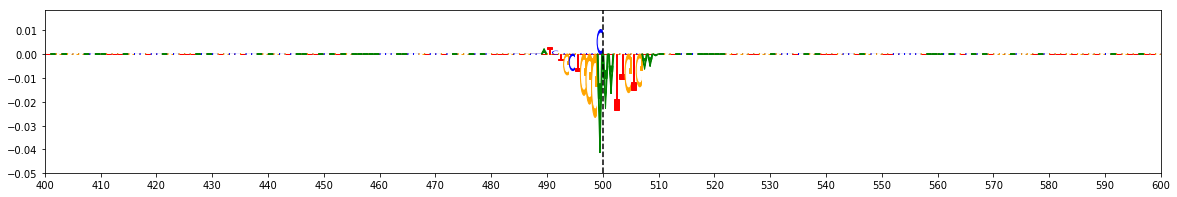


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 162   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.3403   ||  Center / 200bp: 0.5705
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


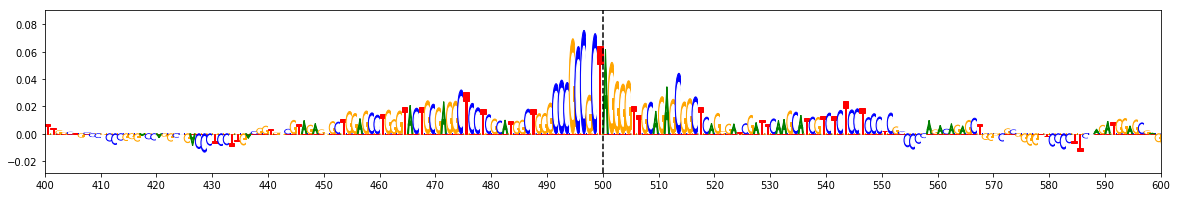

Noneffect Allele: G   ||  Explain Score: 0.9454   ||  Center / 200bp: 0.4839
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


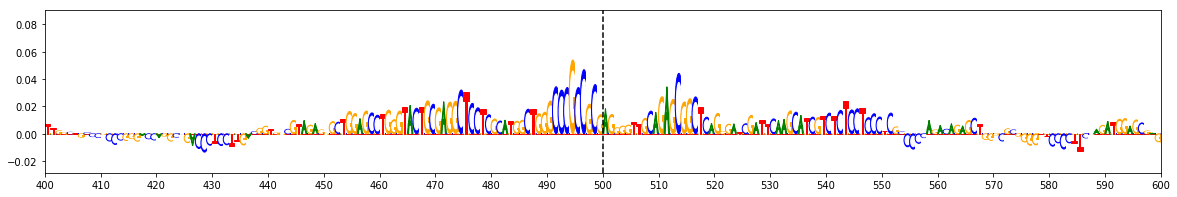

Allele Ratio : 1.4177   ||   Allele Difference : 0.3949  ||  ISM Score : 0.616  ||  deltaSVM Score : 3.5152


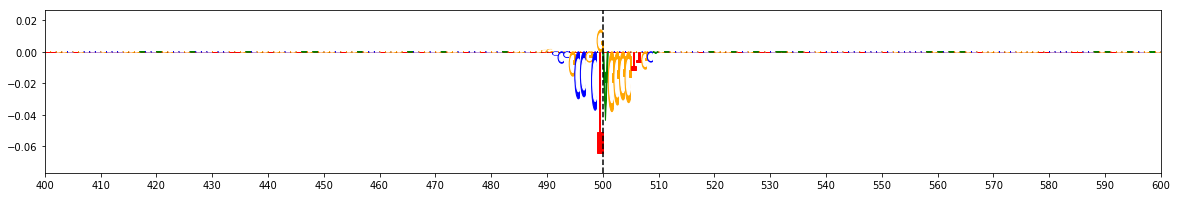


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 17   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.98E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.2832   ||  Center / 200bp: 0.5024
Effect Sequence: GAAACAGGCTCCTTCTCTTC


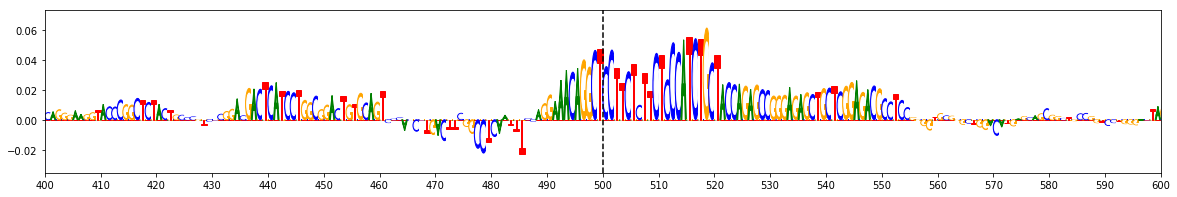

Noneffect Allele: C   ||  Explain Score: 0.805   ||  Center / 200bp: 0.3879
Noneffect Sequence: GAAACAGGCCCCTTCTCTTC


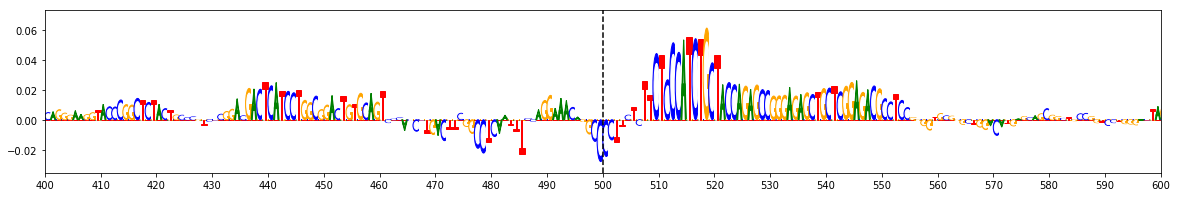

Allele Ratio : 1.594   ||   Allele Difference : 0.5923  ||  ISM Score : 0.922  ||  deltaSVM Score : 5.2903


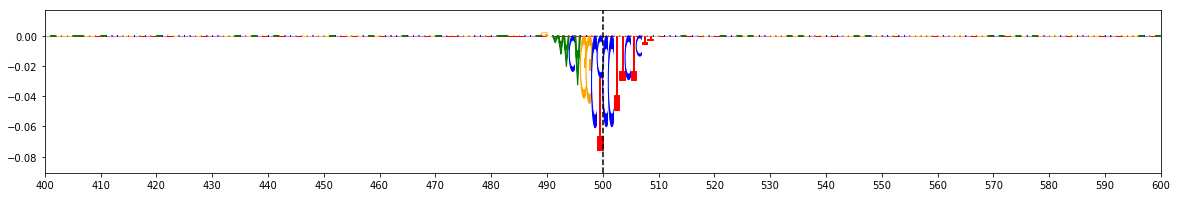


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150125   ||    chr17 : 45909065 - 45909066   ||    Locus: 171   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.31E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7372   ||  Center / 200bp: 0.5376
Effect Sequence: GATCCCAGCGGGAGCTGCAG


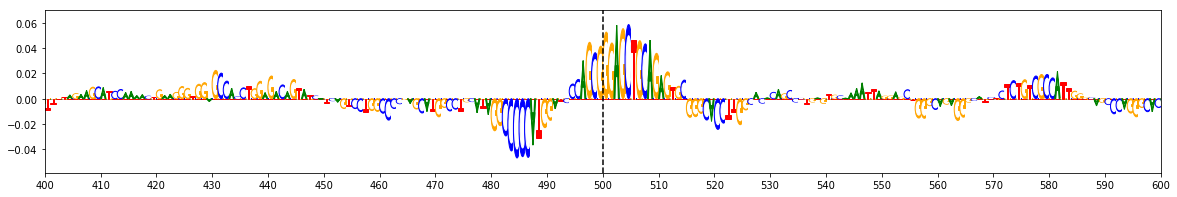

Noneffect Allele: A   ||  Explain Score: 0.5052   ||  Center / 200bp: 0.4436
Noneffect Sequence: GATCCCAGCAGGAGCTGCAG


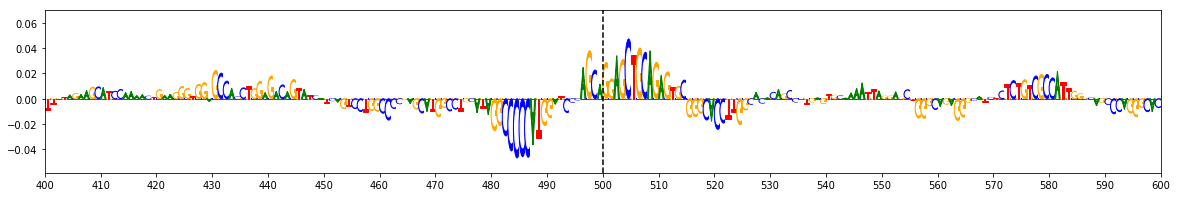

Allele Ratio : 1.4591   ||   Allele Difference : 0.234  ||  ISM Score : 0.3681  ||  deltaSVM Score : 2.1035


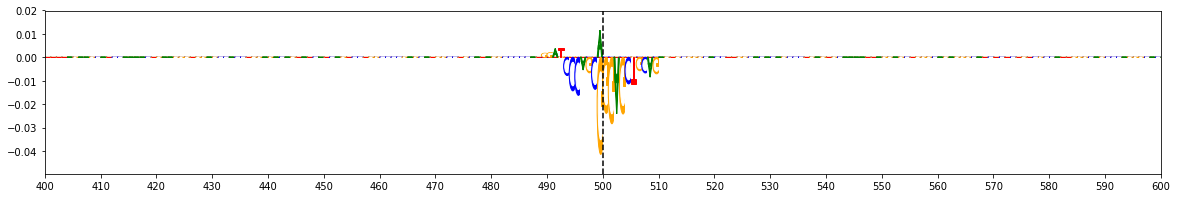


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2668662   ||    chr17 : 46213392 - 46213393   ||    Locus: 212   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.45E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7565   ||  Center / 200bp: 0.6863
Effect Sequence: TCCGCCTGCTGGGTTCACAC


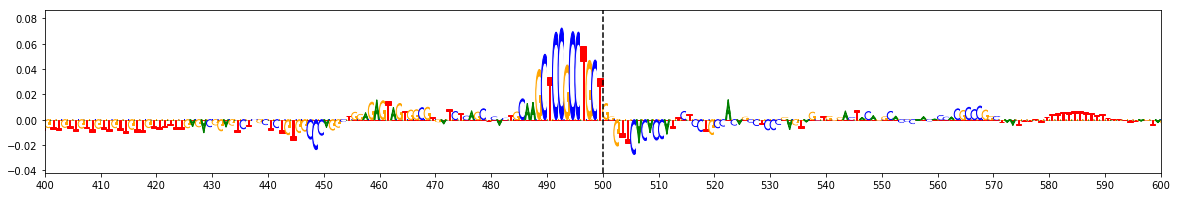

Noneffect Allele: C   ||  Explain Score: 0.6631   ||  Center / 200bp: 0.6572
Noneffect Sequence: TCCGCCTGCCGGGTTCACAC


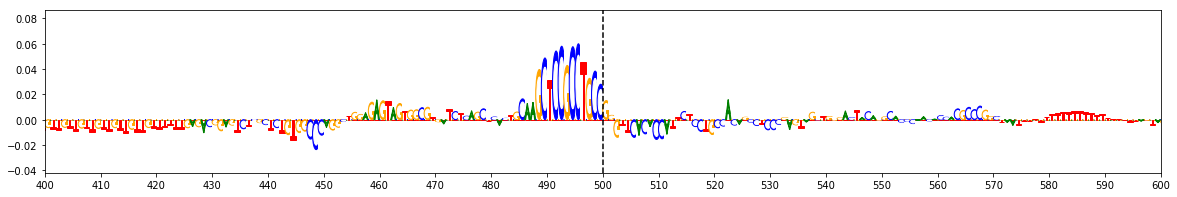

Allele Ratio : 1.1408   ||   Allele Difference : 0.0381  ||  ISM Score : 0.0696  ||  deltaSVM Score : 0.4415


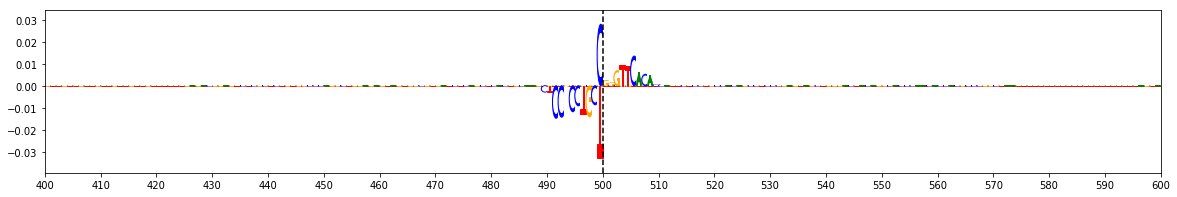


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()